# Overview
The objective of this notebook is to perform data pre-processing on the dataset from Capstone 2 Exploratory Data Analysis(EDA) to prepare it for modelling by clustering.

The process will involve creating dummy features and splitting of data into training and testing subsets.

Inspection comments (and other variables) will be used in the dataframe containing food safety scores (scores_df) to determine if inspection scores or grades can be predicted from features such as inspection comments, date of inspection, type of water, area code, etc.

In [1]:
# Install librtaries
! pip install wordcloud

# Import relevant libraries and packages.

# Basic libraries
import numpy as np 
import pandas as pd 

# Vizualization
import matplotlib.pyplot as plt 
import seaborn as sns 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Text analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import punkt
from nltk import punkt
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re 

# Model pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# For handling error messages.
import warnings 

# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from os import path

First import two spreadsheets into the dataframe. 'allinspections_eda.csv' contains the resultant dataframe from EDA and will be used to train the data. The second spreadsheet, 'food-health-inspections_3.csv' will be used to test the model in the future.

In [2]:
# Read in all the csv files

# food-health-inspections_3 contains information about different kind of establishments, inspection scores, inspection comments,
# date of inspection, etc.
scores_df = pd.read_csv('food-health-inspections_3.csv')

C:\Users\fabby\AppData\Local\Temp\ipykernel_12664\501540096.py:5: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  scores_df = pd.read_csv('food-health-inspections_3.csv')


In [3]:
# Creat word clouds by type of establishment

# Cycle through each establishment type, create a dataframe of the lemmas for each type and plot it
def create_wordcloud(df, establishments, lemma_col):
    for item in establishments:
        dframe = df[df['rpt_area_desc'] == item]
        text = ' '.join(lemma for lemma in dframe[lemma_col]) # Create text for each establishment type
        wordcloud = WordCloud(background_color = 'white', max_words = 200).generate(text) # Create and generate a word cloud image
        plt.imshow(wordcloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.title(item)
        plt.show()

Inspect the scores_df dataframe, the clean and split into training and test sets.

In [4]:
# Inspect the columns of scores_df
scores_df.head(1)

,index,update_user_id,score_sum,end_inspection_ampm,comments,seats,com_num,premise_name,delete_mark,travel_time_min,...,mileage,permit_status_id,ampm_of_inspection,followup_id,rpt_area_desc,time_of_inspection,chlorine_sum,bromine_sum,est_group_id,inspection_reason_desc
0,0,NaN,100.0,NaN,NaN,NaN,NaN,NaN,ACTIVE,0.0,...,NaN,1.0,NaN,NO,Food Service,NaN,NaN,NaN,NaN,NaN


In [5]:
# Print out details of the columns of scores_df
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112046 entries, 0 to 112045
Data columns (total 88 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   index                       112046 non-null  int64  
 1   update_user_id              45304 non-null   float64
 2   score_sum                   96946 non-null   float64
 3   end_inspection_ampm         33162 non-null   object 
 4   comments                    20979 non-null   object 
 5   seats                       2330 non-null    float64
 6   com_num                     0 non-null       float64
 7   premise_name                15689 non-null   object 
 8   delete_mark                 112046 non-null  object 
 9   travel_time_min             107515 non-null  float64
 10  biguanide_sum               35 non-null      float64
 11  action_code_desc            0 non-null       float64
 12  travel_time_hrs             107515 non-null  float64
 13  water_temp_sum

There are 87 features in the scores_df. We will take a closer look at the values in each of these columns and determine which do not add information for the analysis.

In [6]:
#Calculate percentage of null values in each column
def print_pctnull(df):
    pct = round((df.isnull().sum()/len(df)*100),1).sort_values(ascending = False)
    for idx,ent in zip(pct.index, pct.to_numpy()):
        print(idx + ': ' + str(ent))

# print percentage of nulls in df 
print_pctnull(scores_df)

epi_type_desc: 100.0
complaint_section: 100.0
action_code_id: 100.0
rpt_area_num: 100.0
mileage: 100.0
est_type_num: 100.0
permit_status: 100.0
oss_id: 100.0
field59: 100.0
void_date: 100.0
ehs_num: 100.0
permit_type_id: 100.0
oss_num: 100.0
action_code_desc: 100.0
sample_attendance: 100.0
biguanide_sum: 100.0
cdp_est_num: 100.0
request_number: 100.0
com_num: 100.0
inspection_reason_id: 99.9
inspection_reason_desc: 99.9
bromine_sum: 99.9
water_temp_sum: 99.3
verification_required_date: 99.1
seats: 97.9
smoking_allowed: 97.9
est_group_desc: 97.8
est_group_id: 97.8
chlorine_sum: 96.9
water_ph_sum: 96.8
classification_desc: 96.6
classification_id: 96.6
person_incharge_lname: 94.7
person_incharge_fname: 94.6
num_repeat_rf_inter_viol: 87.8
geolocation: 86.1
premise_name: 86.0
num_rf_inter_viol: 84.2
comments: 81.3
image_file_path: 71.8
image_file_name: 71.8
time_of_inspection: 71.6
end_inspection_ampm: 70.4
end_time_of_inspection_hh: 70.4
end_time_of_inspection_mm: 70.4
ampm_of_inspection: 

In [7]:
# Print unique values for each column
df_score_columns = scores_df.columns

for column in df_score_columns:
    print(column + ': ' + str(scores_df[column].unique()))

index: [     0      1      2 ... 112043 112044 112045]
update_user_id: [  nan 1145.  974.  791.  790. 1124.  792.  842.  800. 1355.  798.  794.
  795.  801.  965.  805.  789.  804.  799.   46.  797.  803.  921.  796.
  802.  787.  793.  788. 1431. 1572. 1346. 1527. 1640. 1701. 1566. 1432.
 1116. 1284. 1283. 1412. 1268. 1714. 1119. 1471.]
score_sum: [100.   0.   6.  nan  99.  96.  98.   4.  97.   8.  93.  94.  95.   2.
  92.  25.  12.   7.  18.  17.  86.  90.  22.  10.  30.   9.  89.   1.
   5.  87.  14.  15.  91.   3.  11.  82.  16.  26.  84.  88.  29.  19.
  79.  20.  24.  28.  13.  85.  78.  34.  32.  38.  21.  81.  83.  40.
  76.  27.  74.  72.  80.  33.  77.  31.  75.  23.  48.  36.  42.]
end_inspection_ampm: [nan 'AM' 'PM']
comments: [nan
 '.2815(e)  Hot water used for cleaning and sanitizing food utensils and laundry shall be provided at a minimum temperature of 120 degrees F at the point of use.  The water in the kitchen was about 112 degrees F.  Please. have the kitchen sink tu

est_id: [ 56537  56538  56539 ... 122015 122017 122044]
water_ph_sum: [ nan  7.6  7.5  7.3  7.8  7.2  7.4  7.7  7.   6.8  8.2  0.   8.1  4.6
  6.2  1.5  8.   1.6  0.6  6.6  7.1  0.1  0.7  7.9  6.9  9.8  1.3  1.
  6.  17.3 78.8  3.4  3.3  9.   3.1  8.4  1.4  2.5  9.5  1.8  3.2]
end_time_of_inspection_hh: [nan 10.  1. 12.  4.  2. 11.  8.  3.  5.  9.  7.  6.  0. 13. 16. 17. 22.]
inspection_time_min: [  0.  15.  30.   5.   3.  45.  20.  35.  47.  10.  44.  nan   8.  25.
  51.   2.  50.   4.  40.  55.   6.  41.  18.  57.  16.  11.  17.   1.
  22.  14.  38.  48.  43.  29.  33.  32.  52.  59.  26.   7.  12.  37.
  23.  39.  56.  27.  13.   9.  58.  31.  36.  21.  24.  34.  28.  19.
  53.  42.  49.  46. -53.  54. -30.  -2. -58.  -5. -50. -45. -15. -25.
  -8.  -1.  -7. -21. -38.  -9. -47. -43. -40. -41. -16.  -6. -56. -51.
 -10. -55. -29. -37. -39. -32.]
num_rf_inter_viol: [nan  0.  3.  6.  5.  2.  4.  1.  7.  8.  9. 13. 11. 10.]
extra_credit: ['N' 'Y']
origin: [5 1]
geolocation: [nan "{'lat': 

group_code_id: [ 1. nan  0.]
request_number: [nan]
state_id: [4032011124 4032011125 4032011126 ... 4032720132 4032720174 4032720177]
smoking_allowed: [nan 'N' 'Y']
classification_desc: [nan 'Provisional' 'Superior' 'Approved' 'Disapproved']
permit_status: [nan]
sample_attendance: [nan]
sample: ['N' 'Y']
comment_sheet_id: ['NO' 'YES']
sent_to_bets_yn: ['YES' 'NO']
id: [ 905658  905662  905664 ... 1818093 1818100 1818270]
violations_id: [0]
inspection_time_hrs: [  0.   1.   2.  nan   4.   3.   6.  14.  12. -11. -10.  13.  -1.  -8.
  -7.  -9. -12.  11.  23.   5. -15. -14.   7.   9. -13.  -3.  -2.  -6.
  10.  21.  -5.]
setup_date: ['2008-05-22' '2014-06-03' '2014-06-04' ... '2016-01-30' '2016-10-15'
 '2013-07-19']
time_of_inspection_mm: [nan 30.  0. 45. 15. 59. 20. 54. 33. 40. 35. 14. 25. 50.  5.  7.  1.  6.
 57. 10. 29. 52. 13. 28.  9. 51. 34. 55. 24. 32.  3. 46.  2. 17. 16.  4.
 23. 43.  8. 48. 18. 42. 19. 36. 58. 22. 37. 41. 39. 12. 27. 26. 21. 11.
 31. 44. 47. 53. 38. 56. 49.]
mileage:

In [8]:
# Separate out longitudes and latitudes from geolocation column

# Convert 'geolocation column to string type
scores_df = scores_df.astype({'geolocation': str})

# Split the geolocation string into two parts in geo_list
scores_df['geo_list'] = [row.split(',') for row in scores_df['geolocation']]

# Enter the first element from the list in each row of geo_list in the new column, lat
scores_df['lat'] = [row[0] for row in scores_df['geo_list']]

# Remove characters that are not numerical, '.', or '-' from lat
scores_df['lat'] = [re.sub("[^0-9,.,-]","",string) for string in scores_df.lat]

# Enter the last element from the list in each row of geo_list in the new column, lon
scores_df['lon'] = [row[-1] for row in scores_df['geo_list']]

# Remove characters that are not numerical, '.', or '-' from lon
scores_df['lon'] = [re.sub("[^0-9,.,-]","",string) for string in scores_df.lon]



Despite the score_sum and grade columns contain missing values (13 % and 51%, respectively), we will leave both because those are the target features for the analysis. We will check if we can fill in more grades based on the score_sum value. 

We will min and max values of scores in grades A, B, and C to guide assignments of scores that do not have grades. 

<Axes: xlabel='score_sum', ylabel='grade'>

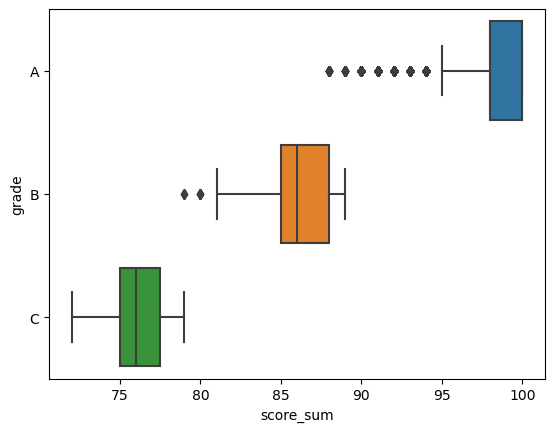

In [9]:
# Plot the box plot of scores by grade.
sns.boxplot(x = 'score_sum', y = 'grade', data = scores_df)

In [10]:
# Calculate the min and max score by grade letters
scoresdf_A = scores_df[scores_df['grade'] == 'A']
scoresdf_B = scores_df[scores_df['grade'] == 'B']
scoresdf_C = scores_df[scores_df['grade'] == 'C']

print('Min A: ' + str(scoresdf_A['score_sum'].min()),'Max A: ' + str(scoresdf_A['score_sum'].max()))
print('Min B: ' + str(scoresdf_B['score_sum'].min()),'Max B: ' + str(scoresdf_B['score_sum'].max()))
print('Min C: ' + str(scoresdf_C['score_sum'].min()),'Max C: ' + str(scoresdf_C['score_sum'].max()))

Min A: 88.0 Max A: 100.0
Min B: 79.0 Max B: 89.0
Min C: 72.0 Max C: 79.0


Scores within the range 100 - 90 will B assigned A, 90 - 80 will be assigned B, and below 79 bwill be assigned C.

In [11]:
# Assign grade for each observation that has a score_sum value and has no grade score
index = scores_df[(scores_df['score_sum'].notnull()) & (scores_df['grade'].isnull())].index.to_list()

for idx in index:
    # If score is between 100 and 90 (both included) assign A grade
    if ((scores_df.iloc[idx,1] <= 100) &  (scores_df.iloc[idx,1] >= 90)): 
        scores_df.iloc[idx, 41] = 'A'
    # If score is between 90 and 80 (80 included) assign B grade  
    elif ((scores_df.iloc[idx,1] < 90) &  (scores_df.iloc[idx,1] >= 80)):
          scores_df.iloc[idx, 41] = 'B'
    # If score is below 80 assign C grade
    else:
          scores_df.iloc[idx, 41] = 'C'


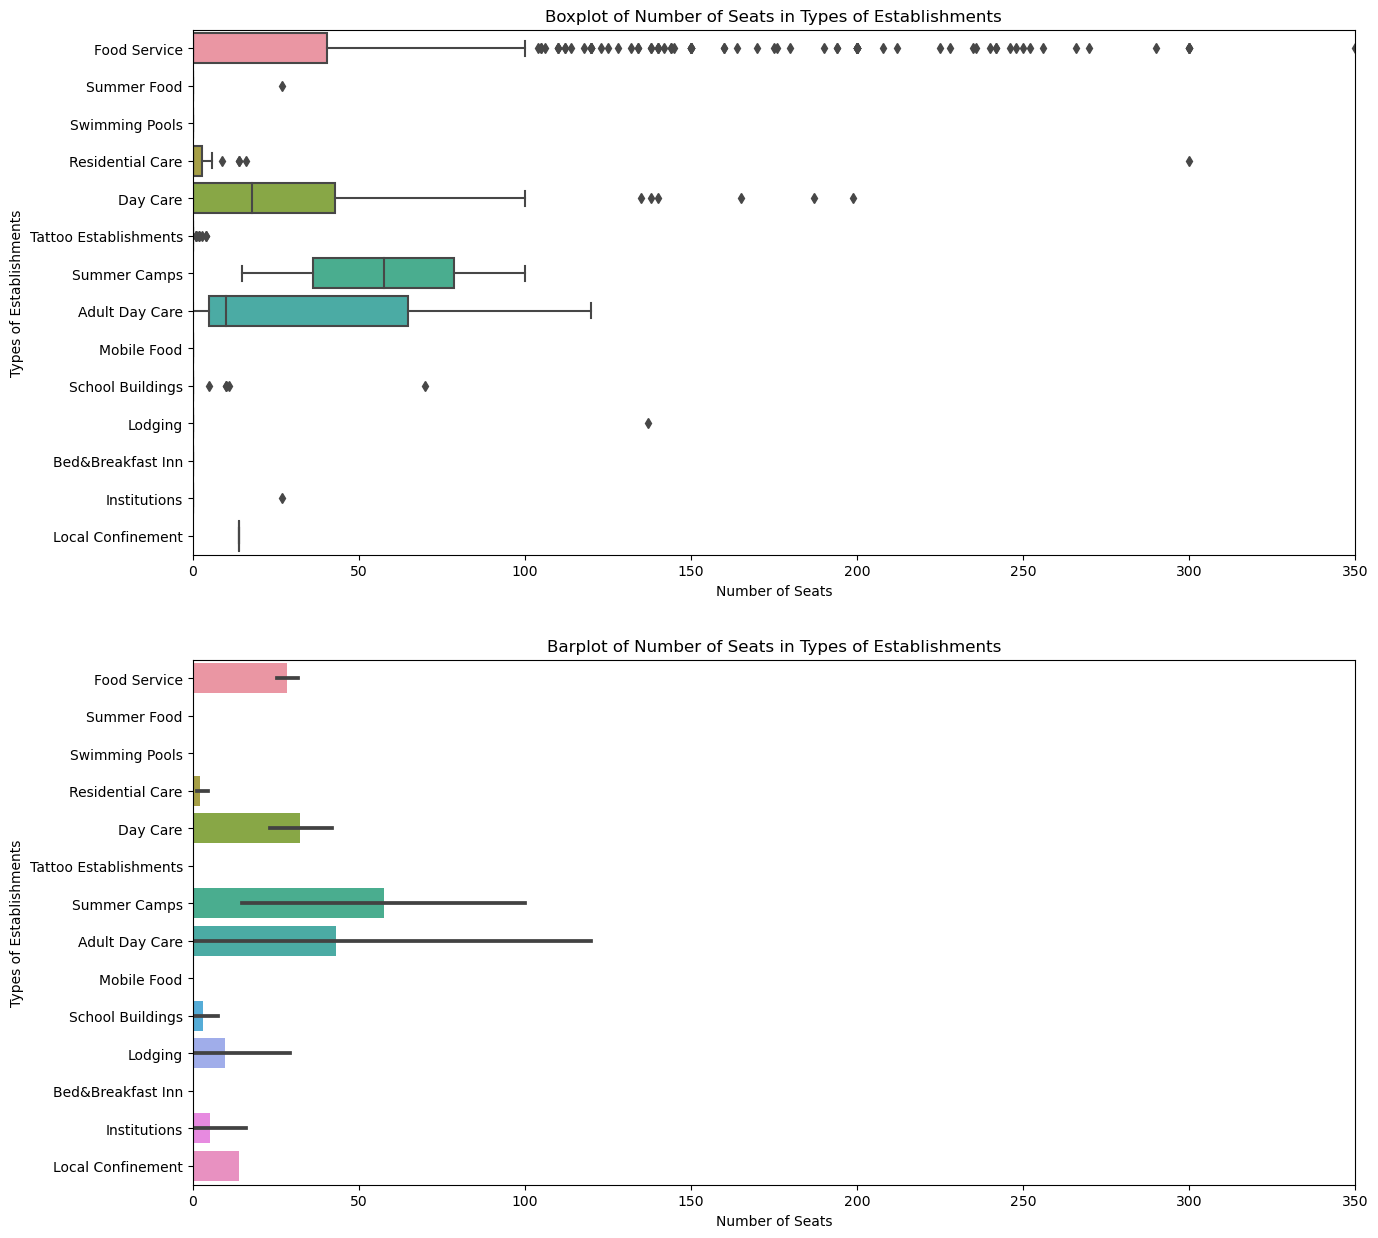

In [12]:
# Investigate the entries of the seating column

seats_df = scores_df.dropna(subset = ['seats', 'rpt_area_desc'])
                            
# Create a plot of  seats by kind of establishments from scores_df.
fig, axes = plt.subplots(2, 1, figsize=(15,15), sharey = True)
sns.boxplot(x = 'seats', y = 'rpt_area_desc', data = seats_df, ax = axes[0])
sns.barplot(x = 'seats', y = 'rpt_area_desc', data = seats_df, ax = axes[1])

# Set title of each plot 
axes[0].set_title('Boxplot of Number of Seats in Types of Establishments')
axes[1].set_title('Barplot of Number of Seats in Types of Establishments')

# Set y-axis label of each plot 
axes[0].set_ylabel('Types of Establishments')
axes[1].set_ylabel('Types of Establishments')

# Set x-axis label of each plot 
axes[0].set_xlabel('Number of Seats')
axes[1].set_xlabel('Number of Seats')

# Set limit of x-axis
axes[0].set_xlim(0, 350)
axes[1].set_xlim(0, 350)

plt.show()

We observe that summer camps, daycares, adult day cares and food service, and day cares have the most capacity for customers. There are numerous outliers for foodservice according to the boxplot that are not captured in the barplot. Summer food, local confinements, tattoo establishments, swimming pools, mobile food, Bread&Breakfasts, lodgings and institutions do not have any seats recorded. This only makes sense for an establishment like mobile food where it is only a mobile kitchen without seating areas for customers. It was expected that other locations like would have more seating. It could be that the data was entered as zero as a default because the amount of seats was unknown.

Due to the incomplete information on seating, this column will not be used for modelling.

In [13]:
# Drop null values from comments, grades, and score_sum and revaluate the number of null values
scores_df = scores_df.dropna(subset = ['comments', 'grade','score_sum'])
print_pctnull(scores_df)

verification_required_date: 100.0
field59: 100.0
rpt_area_num: 100.0
action_code_id: 100.0
permit_type_id: 100.0
complaint_section: 100.0
request_number: 100.0
mileage: 100.0
oss_id: 100.0
void_date: 100.0
epi_type_desc: 100.0
person_incharge_lname: 100.0
sample_attendance: 100.0
inspection_reason_id: 100.0
cdp_est_num: 100.0
permit_status: 100.0
oss_num: 100.0
est_type_num: 100.0
person_incharge_fname: 100.0
com_num: 100.0
inspection_reason_desc: 100.0
action_code_desc: 100.0
ehs_num: 100.0
seats: 99.8
biguanide_sum: 99.8
est_group_desc: 99.6
est_group_id: 99.6
bromine_sum: 99.4
smoking_allowed: 97.7
water_temp_sum: 95.1
num_rf_inter_viol: 85.8
num_repeat_rf_inter_viol: 85.8
classification_id: 80.9
classification_desc: 80.9
chlorine_sum: 78.7
water_ph_sum: 78.3
premise_name: 74.2
group_code_id: 70.2
end_inspection_ampm: 53.0
end_time_of_inspection_mm: 52.9
end_time_of_inspection_hh: 52.9
image_file_name: 50.9
image_file_path: 50.9
time_of_inspection: 50.8
ampm_of_inspection: 45.8
time

Columns that have null values over 5% we will dropped from the dataframe.

In [14]:
# Create list of column names where percentage of null values are greater than 5%.

# Calculate the % null for each column
pct = round((scores_df.isnull().sum()/len(scores_df)*100),1).sort_values(ascending = False)

# Create dataframe and reset index where indices are column names and pct are the calculated values
pct_df = pd.DataFrame(pct.index, pct).reset_index()

# Rename columns, with index as calculated column, pct_null, and 0 as column name, col_name.
pct_df = pct_df.rename(columns = {'index':'pct_null',0:'col_name'})

# From the dataframe drop column names corresponding to pct_nulls that are greater than 5%.
col_drop = pct_df['col_name'][pct_df['pct_null'] > 5]

# Convert the columns to a list.
col_drop = col_drop.to_list()

In [15]:
# Drop col_drop columns from scores_df
scores_df = scores_df.drop(columns = col_drop)

In [16]:
# Drop additional redundant columns of columns that do not add information, or not understood

scores_df = scores_df.drop(columns = ['index','delete_mark','epi_type_id','insp_type','est_type', 'est_id', 'origin','geolocation', 'county', 'update_date',\
'district', 'final_score_sum','state_id', 'sample', 'comment_sheet_id', 'sent_to_bets_yn','id','violations_id',\
'setup_date', 'followup_id', 'geo_list'])

In [17]:
# Convert inspection date column to datetime format
scores_df['insp_date']= pd.to_datetime(scores_df['insp_date'])

In [18]:
# Create month and year columns for scores_df from the insp_date column to investigate how inspection scores vary by year.
scores_df['year'] = scores_df['insp_date'].dt.year
scores_df['month'] = scores_df['insp_date'].dt.month

In [19]:
# Group the dataframe by type of establishment and year, and calculate the inspection score for these groupings.
time_trend_group = pd.DataFrame(scores_df.groupby(['rpt_area_desc','year'])['score_sum'].mean()).reset_index()

C:\Users\fabby\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


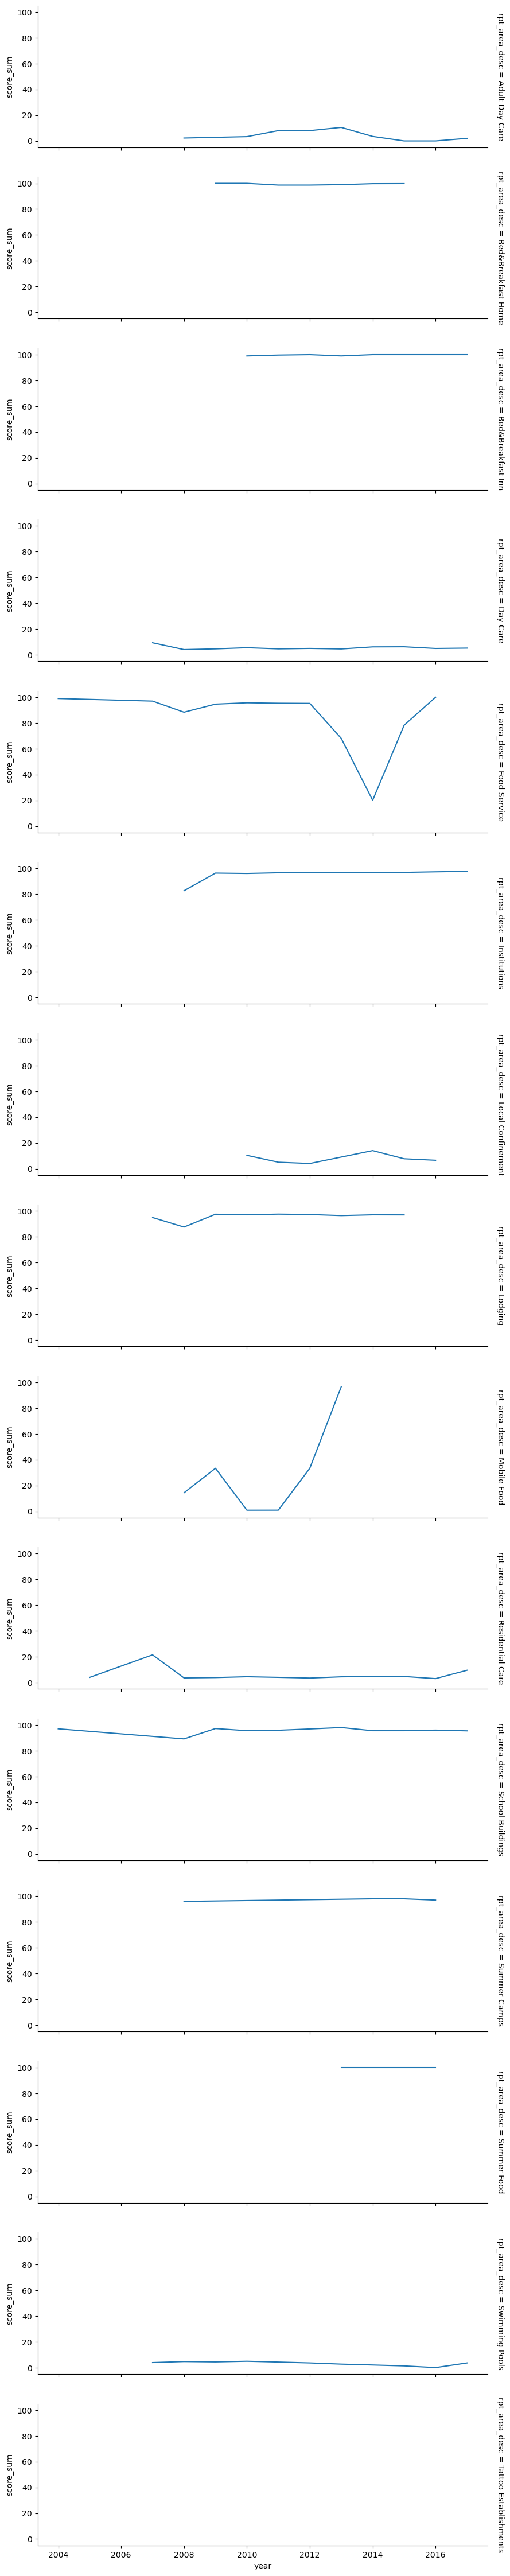

In [20]:
# Plot average inspection score by year for each type of establishment.
g = sns.FacetGrid(time_trend_group, row = 'rpt_area_desc', margin_titles = True, height = 3, aspect = 3)
g.map(sns.lineplot, "year", "score_sum")

From the plots it seems places that mainly serve food or have an aspect of food service have high inspection scores. There are no inspection scores observed for tattoo establishments. It is unlikely that tattoo parlors have inspection scores of zero. The entry could have been made if the value was low. Other establishments have low scores as well but it is difficult to verify whether they are incorrect entries or not. They will be kept as is until additional information is given.

# Word Processing

Remove punctuation from comments column and standardize the case to lower case.

In [21]:
# Remove comments from the comments column of the dataframe.
scores_df['text'] = [re.sub("[^A-Za-z]"," ",string) for string in scores_df.comments]
scores_df['text'] = scores_df['text'].str.lower()

Tfidf Vectorizer will be used to vectorize the words in each column and treat each column as a 'document' in a collection of documents. Once the columns are vectorized, a word cloud will be created for each type of establishment.

In [22]:
# Create a set of stop words
stop_words = set(stopwords.words('english'))

# Initiate the wordnetlemmatizer function
wnl = WordNetLemmatizer() 


# Create tokens from the text column strings
scores_df['tokens'] =  scores_df.apply(lambda row: word_tokenize(row['text']), axis = 1 )

# Remove stopwords
scores_df['tokens'] =  scores_df.apply(lambda row: [word for word in row['tokens']\
                                                                          if word not in stop_words], axis = 1)
# Create lemmas
scores_df['lemmas'] = scores_df.apply(lambda row: [wnl.lemmatize(word) for word in\
                                                                              row['tokens']], axis = 1)

# Form lemmas into a full string
scores_df['lemmas'] = scores_df.apply(lambda row: ' '.join(row['lemmas']), axis = 1)

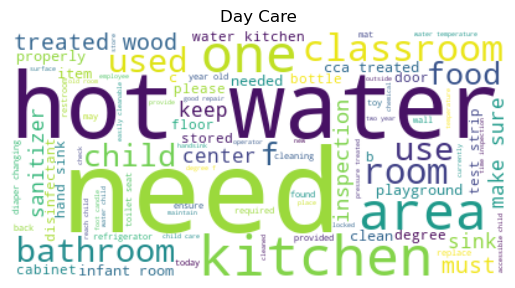

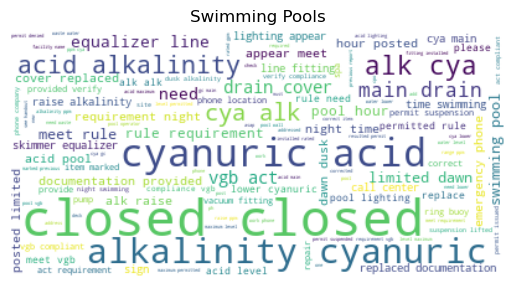

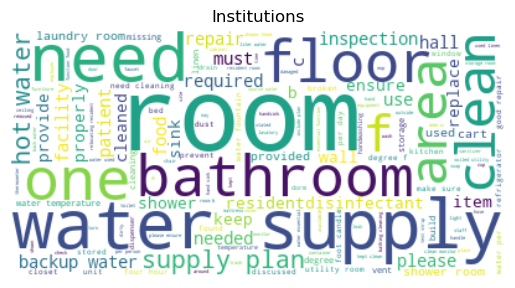

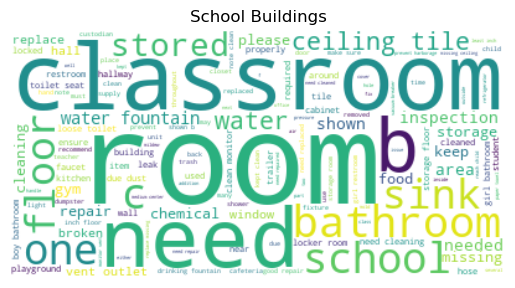

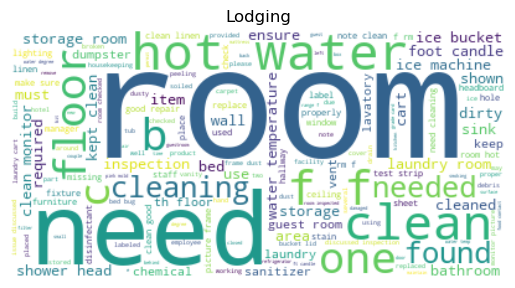

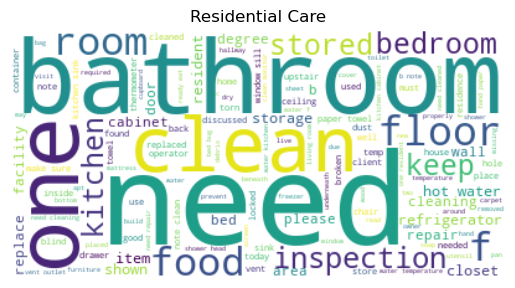

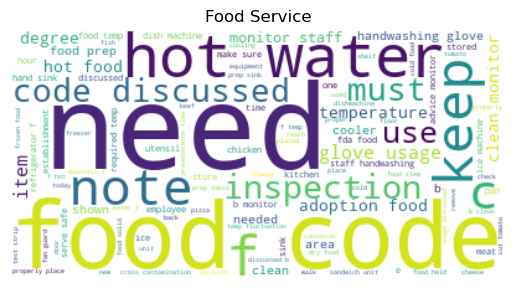

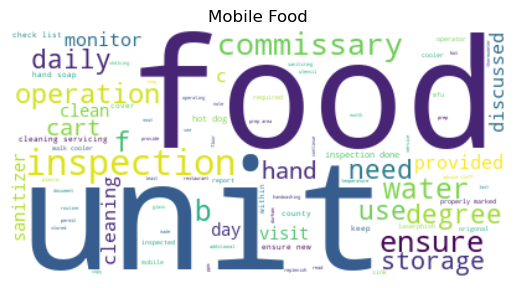

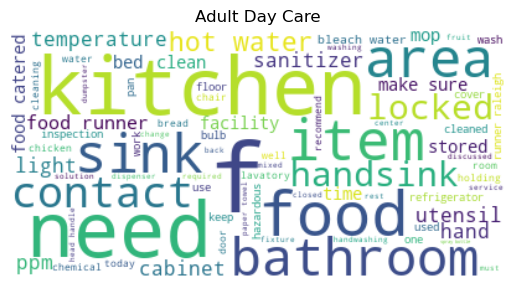

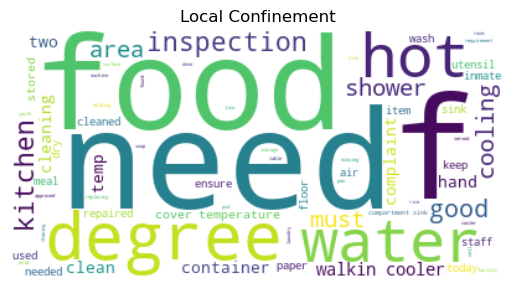

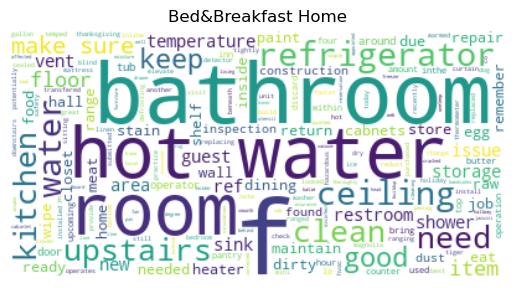

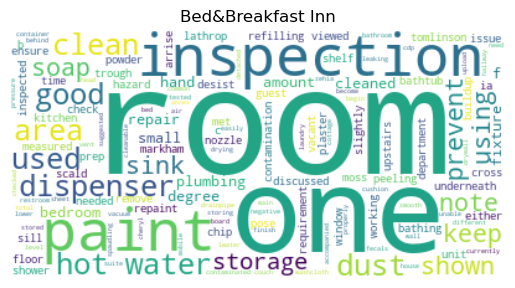

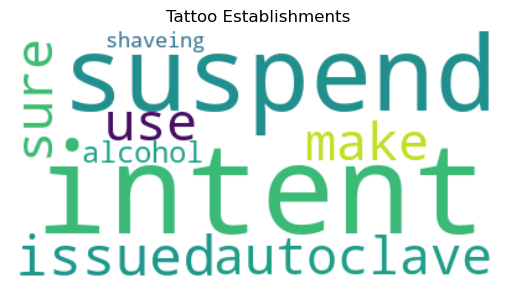

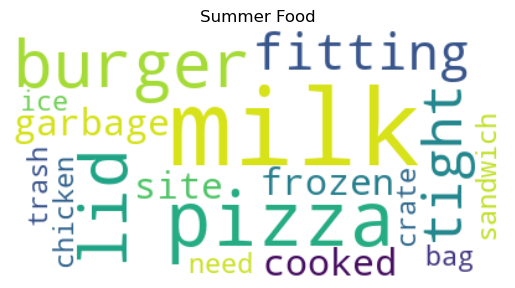

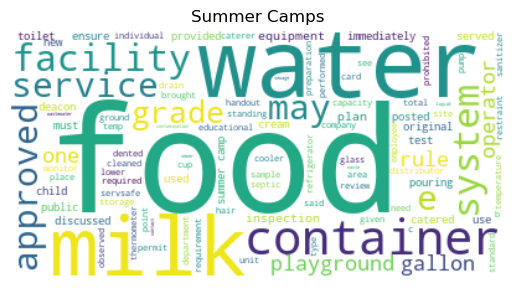

In [23]:
# Creat word clouds by type of establishment

# Create a list of establishments
scores_est = list(scores_df['rpt_area_desc'].unique())
        
# Run word cloud function on scores df
create_wordcloud(scores_df, scores_est, 'lemmas')  

In [24]:
# Inspect datatypes in scores_df
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10957 entries, 1432 to 112045
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   score_sum          10957 non-null  float64       
 1   comments           10957 non-null  object        
 2   sewage             10957 non-null  int64         
 3   type_description   10957 non-null  object        
 4   insp_date          10957 non-null  datetime64[ns]
 5   water              10957 non-null  int64         
 6   rpt_area_code      10957 non-null  int64         
 7   extra_credit       10957 non-null  object        
 8   grade              10957 non-null  object        
 9   ehs                10957 non-null  int64         
 10  territory          10955 non-null  float64       
 11  est_num            10956 non-null  float64       
 12  ehs_id             10957 non-null  int64         
 13  six_point_demerit  10957 non-null  object        
 14  permit_

In [25]:
# Create dummy variables for features which are not target features, floats, or redundant features. Note text and
# token columns will be deleted later, while lemmas will be vectorized.

# Complete one hot encoding of object features that are not targets or to be used in analysis.
scores_df_dummy = pd.get_dummies(scores_df,columns = ['type_description','extra_credit', 'six_point_demerit', 'rpt_area_desc'],\
                                drop_first = True, prefix = 'D')

In [26]:
# Initiate tfidfvectorizer
tv = TfidfVectorizer(max_features = 200, stop_words = 'english')

# Fit and transform the text column
tv.fit(scores_df_dummy['lemmas'])
train_tv_transformedsc = tv.transform(scores_df_dummy['lemmas'])

# Create array of transformed text
train_tv_dfsc = pd.DataFrame(train_tv_transformedsc.toarray(), columns = tv.get_feature_names_out()).add_prefix('TFIDF_')

# Equate indices to void creation of Nan rows during concatination
scores_df_dummy.index = train_tv_dfsc.index

scores_df = pd.concat([scores_df_dummy, train_tv_dfsc], axis = 1, sort = False)

In [27]:
# Examine the data
examine_rowsc = train_tv_dfsc.iloc[0]
print(examine_rowsc.sort_values(ascending = False).head(3))

TFIDF_solution    0.356786
TFIDF_toilet      0.311644
TFIDF_degree      0.309207
Name: 0, dtype: float64


In [28]:
# Convert 'lat' and 'lon' to float type
# Remove any character that is not a digit or '.' from each column lat
#scores_df['lat'] =  scores_df.apply(lambda row: [''.join(char for char in row['lat'] if char.isdigit() or char == '.')],\
                                                 #axis = 1)

# Remove any character that is not a digit or '.' from each column lon    
#scores_df['lon'] =  scores_df.apply(lambda row: [''.join(char for char in row['lon'] if char.isdigit() or char == '.')],\
                                                 #axis = 1)   

#Convert lat and long columns to float type
#scores_df['lat'] = scores_df['lat'].astype(float)
#scores_df['lon'] = scores_df['lon'].astype(float)

Found that numerous rows in lat and lon columns were empty despite being represented as not having null values. This is brining up errors when attempting to convert columns to float type. Both columns will be dropped and rpt_area_code (phone area code) will be used as a corollary for location. We will also drop text and token columns.

In [29]:
# Equate indices to void creation of Nan rows during concatination
#scores_df_dummy.index = scores_df.index

# Concatenate scores_df_dummy with scores df
#final_scoresdf = pd.concat([scores_df,scores_df_dummy], axis = 1 )

# Drop lon, lat, comment associated columns,insp_date, and grades from final_scoresdf, and those turned into
# dummy variables.
# We will only use inspection scores for the target variable, not grades.
final_scoresdf = scores_df.drop(columns = ['lat', 'lon', 'text', 'tokens', 'comments','lemmas','grade',\
                                          'insp_date'])


In [30]:
# Split final_scoresdf into  X and y (inspection scores) components. 

# Convert score_sum column to string and create new target variable, y_sc for Formatted_FC_section
y = final_scoresdf['score_sum']

# Create a new feature variable that contains all independent features by dropping target variables score_sum and grade
X = final_scoresdf.drop(columns = ['score_sum'])

# Split data into test and training set for predicting inspection scores
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
# Scale the numerical features of the dataframe using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Store X_train_scaled, X_test_scaled, y_train, and y_test as csv files that can be read in during the modelling phase.
pd.DataFrame(X_train_scaled).to_csv('Xtrain_scaled.csv')
pd.DataFrame(X_test_scaled).to_csv('Xtest_scaled.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

The training and test sets generated will be used in the modelling step.